In [1]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np
import json, gc, pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import importlib, minmax_solvers
importlib.reload(minmax_solvers)
from minmax_solvers import solve_game_bestresp_Q0_then_Q1
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray


import numpy as np
from numpy.linalg import cholesky, solve, eigh


c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm =50  #  dBm
jam_power_dbm = 70
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)
T_sys = 150.0 
N0 = k * bandwidth * T_sys* La_linear

N0 = noise_power_watt
N0 = 1.38e-23 * 100e6 * T_sys * La_linear
P0 = Tx_power_watt
P1 = Jam_power_watt

jitc_llvm_init(): LLVM API initialization failed ..


In [2]:
from sionna.rt import Receiver, Transmitter, PlanarArray, PathSolver, load_scene
import numpy as np
import vsat_dish_3gpp


def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)
    
    earth_radius_m = 6371e3
    rx_look_at2 = np.array([0.0, 0.0, -1*earth_radius_m/2])
    
    if isinstance(tx_look_at, str) and tx_look_at.lower() in ["up-z", "up", "z"]:
        tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 100.0])
    tx.look_at(tx_look_at)
    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at2)
        rx_list.append(rx)
    tx.look_at( tx_look_at)

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                #    seed=41
                   )

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

jam_rows =1
jam_cols = 1
jam_antennas = jam_cols*jam_rows

sat_rows = 6
sat_cols = 6
sat_antennas = sat_cols*sat_rows

tx_rows = 6
tx_cols = 6
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                            pattern="vsat_dish",
                            # pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t


In [3]:
def make_tqdm_progress(total, desc, position=1, leave=False):
    bar = tqdm(total=total, desc=desc, position=position,
                  leave=leave, dynamic_ncols=True, miniters=1, mininterval=0.0)
    bar.refresh()  
    last_i = 0

    def _cb(i=None, total=None, metrics=None, ctx=None):
        nonlocal last_i
        if i is not None:
            di = int(i) - int(last_i)     
            if di > 0:
                bar.update(di)
                last_i = i
        if metrics:
            show = {k: (f"{v:.3e}" if ("res" in k or "err" in k) else f"{v:.4f}")
                    for k, v in metrics.items()}
            bar.set_postfix(show, refresh=True)  
        return False

    _cb.close = bar.close
    return _cb

In [4]:

# Load and make sure each time block is ordered by Rank (nearest first)
df = pd.read_csv("tracked_satellites_400.csv")
df = df.sort_values(["Time", "Rank"], ascending=[True, True]).reset_index(drop=True)
n_steps = df["Time"].nunique()
print("Total steps:", n_steps)
# max_steps = 3
# print(df.head(max_steps*5))

Total steps: 400


In [5]:
# Generate RX positions

distances_km = [1]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")

TX0(m): [0. 0. 0.]
TX1(m): [ 6.12323397e-14  9.99999996e+02 -7.84806153e-02]


In [7]:

# ---- JSON 序列化器：支持 numpy / complex ----
class NumpyEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, (np.integer,)):  return int(o)
        if isinstance(o, (np.floating,)): return float(o)
        if isinstance(o, (np.complexfloating, complex)):
            return {"__complex__":[float(o.real), float(o.imag)]}
        if isinstance(o, np.ndarray):     return o.tolist()
        return super().default(o)
    


In [8]:
from Dishjammersolver import optimal_Q0



# ============================================================
# =========== 你环境中的数据/通道构建（保持接口一致） ===========
# - 假设你已有：
#   df: 含 "Time","Rank","x_East (m)","y_North (m)","z_Up (m)","Name"
#   groups = list(df.sort_values(["Time","Rank"]).groupby("Time"))
#   compute_cir / collapse_channel / gnd_positions / tx_array / jam_array / sat_array / sat_antennas
#   常量：P0,P1,N0, n_steps
# ============================================================
max_steps = n_steps





groups = list(df.sort_values(["Time","Rank"]).groupby("Time"))

# ---- 单文件（非压缩）增量写入 ----       # 只一个文件


buffer = []                              # 暂存多条，降低 I/O 次数
FLUSH_EVERY = 5                          # 每 5 个 time-step 落盘一次
# ====== 可调参数 ======
methods     = ["WF"]        # 这里方法仅此一项（水填充WF）
sat_counts  = [1, 3, 5]
out_path    = "dishjammer_WF400.jsonl"
f_out = open(out_path, "a", encoding="utf-8")
FLUSH_EVERY = 5
max_steps   = n_steps       # 或者设置成50等
top_keep    = 6             # 为了瘦身，只保存前几个特征值/功率

# ====== 打开输出 ======
f_out  = open(out_path, "a", encoding="utf-8")
buffer = []

# ====== 主循环（与示例写法一致） ======
for step_idx, (t, g) in enumerate(tqdm(groups, desc="Processing steps (WF)"), start=1):
    gk = g.sort_values("Rank").copy()

    sat_positions = gk[["x_East (m)", "y_North (m)", "z_Up (m)"]].to_numpy()
    names         = gk["Name"].tolist()
    K_all         = sat_positions.shape[0]

    # 你已有：通道构建
    a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array,  sat_array,
                                 np.array(gnd_positions[0]) + np.array([0.0, 0.0, 100.0]), gnd_positions[0])
    a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, jam_array,  sat_array,
                                 sat_positions[0], gnd_positions[0])

    H0_full = collapse_channel(a_tx)   # shape: (K*Nr, Nt0)
    H1_full = collapse_channel(a_jam)  # shape: (K*Nr, Nt1)

    for k_sel in sat_counts:
        if K_all < k_sel:
            continue

        # 取前 k_sel 颗卫星（按 Rank）
        H0 = H0_full[:k_sel*sat_antennas, :]
        H1 = H1_full[:k_sel*sat_antennas, :]

        # === 只跑水填充WF（optimal_Q0）===
        method_name = "WF"
        try:
            Q0, Q1, info, C = optimal_Q0(H0, H1, N0=N0, P0=P0, P1=P1)
        except np.linalg.LinAlgError as e:
            # 数值异常时，记录nan以便CDF统计
            info, C = {"rank": 0, "lambdas": [], "p": [], "mu": np.nan, "rate_bpcu": np.nan}, np.nan

        # entry尽量瘦身
        # 只保存前 top_keep 个特征值/功率，方便后续诊断
        lambdas_small = np.asarray(info.get("lambdas", []), float)[:top_keep]
        p_small       = np.asarray(info.get("p", []), float)[:top_keep]

        entry = {
            "time": (pd.Timestamp(t).isoformat() if not pd.isna(t) else None),
            "step_idx": step_idx,
            "method": method_name,
            "k": k_sel,
            "sat_names": names[:k_sel],
            "C_bpsHz": float(C),
            "rank": int(info.get("rank", 0)),
            "mu": float(info.get("mu", np.nan)) if info.get("mu", None) is not None else np.nan,
            "lambdas_top": lambdas_small,
            "p_top": p_small,
        }
        buffer.append(entry)

        del Q0, Q1, entry
        gc.collect()

    # ===== 批量写入 =====
    if (step_idx % FLUSH_EVERY == 0) or (step_idx == len(groups)) or (step_idx >= max_steps):
        for e in buffer:
            f_out.write(json.dumps(e, cls=NumpyEncoder) + "\n")
        f_out.flush()
        buffer.clear()
        gc.collect()
        print(f"[flush] wrote up to step {step_idx}")
    if step_idx >= max_steps:
        break

f_out.close()
print(f"✅ Incremental WF results saved to {out_path}")


Processing steps (WF):   0%|          | 0/400 [00:00<?, ?it/s]

[flush] wrote up to step 5
[flush] wrote up to step 10
[flush] wrote up to step 15
[flush] wrote up to step 20
[flush] wrote up to step 25
[flush] wrote up to step 30
[flush] wrote up to step 35
[flush] wrote up to step 40
[flush] wrote up to step 45
[flush] wrote up to step 50
[flush] wrote up to step 55
[flush] wrote up to step 60
[flush] wrote up to step 65
[flush] wrote up to step 70
[flush] wrote up to step 75
[flush] wrote up to step 80
[flush] wrote up to step 85
[flush] wrote up to step 90
[flush] wrote up to step 95
[flush] wrote up to step 100
[flush] wrote up to step 105
[flush] wrote up to step 110
[flush] wrote up to step 115
[flush] wrote up to step 120
[flush] wrote up to step 125
[flush] wrote up to step 130
[flush] wrote up to step 135
[flush] wrote up to step 140
[flush] wrote up to step 145
[flush] wrote up to step 150
[flush] wrote up to step 155
[flush] wrote up to step 160
[flush] wrote up to step 165
[flush] wrote up to step 170
[flush] wrote up to step 175
[flus

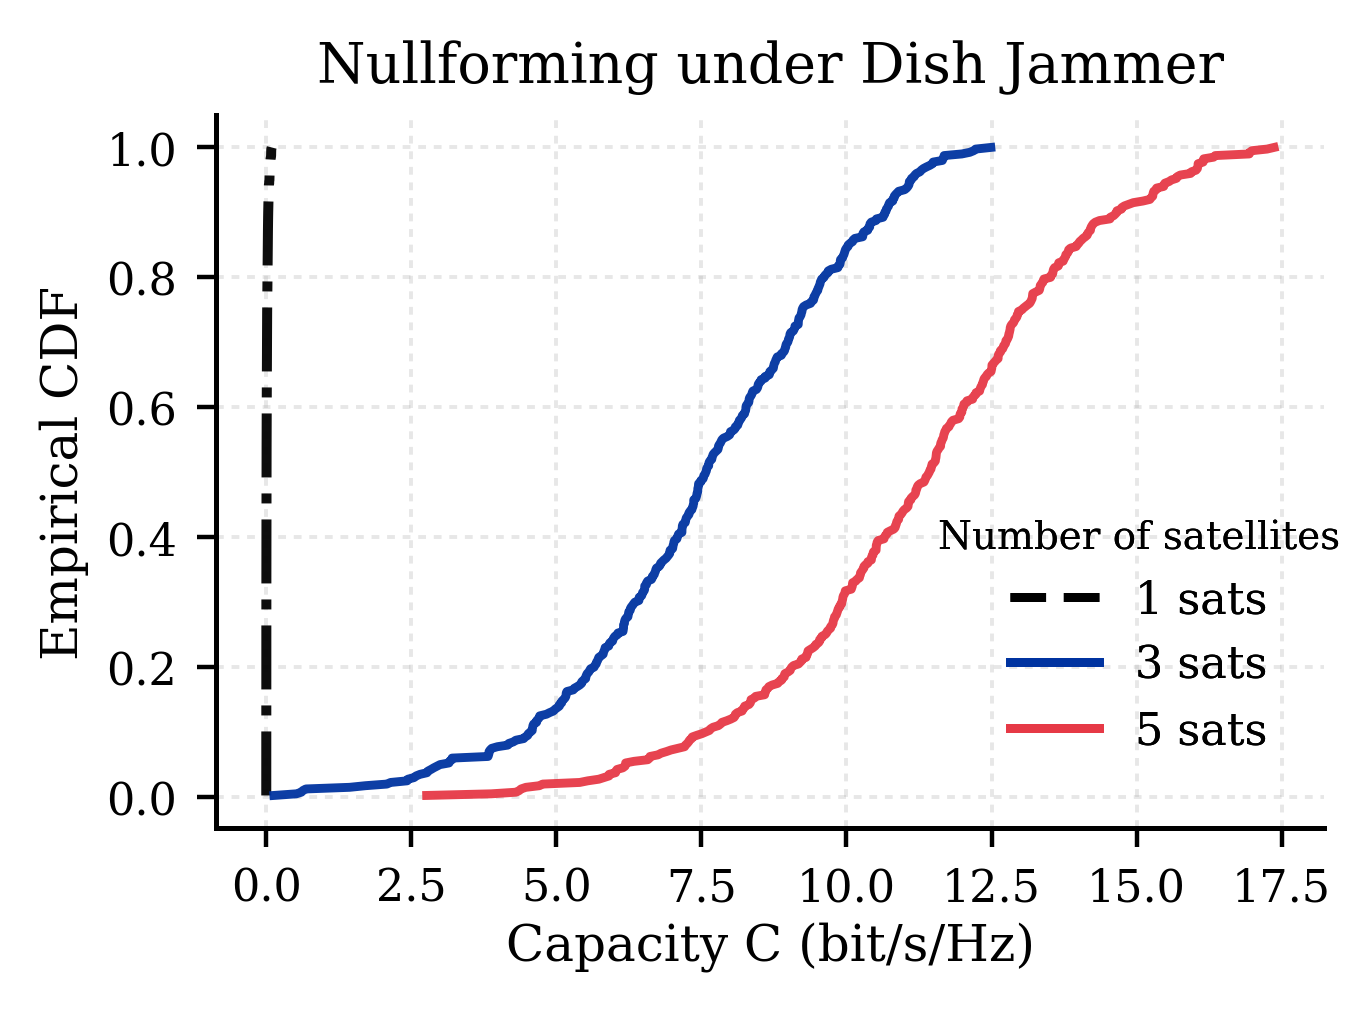

In [19]:
# -*- coding: utf-8 -*-
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# ============== User Config ==============
JSONL_PATHS = ["dishjammer_WF400.jsonl"]
POSTER_MODE = False
MAIN_DPI = 400
TITLE = "Nullforming under Dish Jammer"
X_LABEL = "Capacity C (bit/s/Hz)"
Y_LABEL = "Empirical CDF"
# ========================================

def load_jsonl(paths):
    paths = [Path(p) for p in (paths if isinstance(paths, (list, tuple)) else [paths])]
    rows = []
    for p in paths:
        if not p.exists():
            print(f"[warn] file not found: {p}")
            continue
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    obj = json.loads(line.strip())
                    rows.append(obj)
                except Exception:
                    pass
    if not rows:
        return pd.DataFrame()

    df = pd.DataFrame(rows)
    if "C_bpsHz" in df.columns:
        df["C_bpsHz"] = pd.to_numeric(df["C_bpsHz"], errors="coerce")
    if "k" in df.columns:
        df["k"] = pd.to_numeric(df["k"], errors="coerce").astype("Int64")
    if "method" in df.columns:
        df["method"] = df["method"].astype(str)
    return df

def ecdf(values):
    x = np.sort(values[~np.isnan(values)])
    if x.size == 0:
        return np.array([]), np.array([])
    y = np.arange(1, x.size + 1) / x.size
    return x, y

# -------- Load --------
df = load_jsonl(JSONL_PATHS)
if df.empty:
    raise RuntimeError("No records loaded. Check file paths or run batch first.")

methods = sorted(df["method"].dropna().unique().tolist())
ks = sorted(df["k"].dropna().unique().tolist())

# -------- Figure setup --------
if POSTER_MODE:
    fig_size = (8.5, 6.2)
    base_font = 14
else:
    fig_size = (3.5, 2.6)
    base_font = 9

plt.rcParams.update({
    "font.size": base_font,
    "axes.titlesize": base_font + (2 if POSTER_MODE else 1),
    "axes.labelsize": base_font,
    "xtick.labelsize": base_font - 1,
    "ytick.labelsize": base_font - 1,
    "legend.fontsize": base_font - 1,
    "axes.linewidth": 1.0 if POSTER_MODE else 0.9,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
})

fig, ax = plt.subplots(figsize=fig_size, dpi=MAIN_DPI)

# -------- Softer & brighter color palette --------
colors = ['black', '#0033A0', '#E63946']
linestyles = ["-", "--", "-.", ":"]

lw = 2.2 if POSTER_MODE else 1.6

# -------- Plot --------
for m_idx, m in enumerate(methods):
    for i, k_sel in enumerate(ks):
        vals = df[(df["method"] == m) & (df["k"] == k_sel)]["C_bpsHz"].to_numpy()
        x, y = ecdf(vals)
        if x.size == 0:
            continue

        # 第一条线（黑色）改为柔和虚线
        if i == 0:
            style = '-.'
            line_w = 1.8
        else:
            style = linestyles[m_idx % len(linestyles)]
            line_w = lw
        ax.plot(
            x, y,
            label=f"{k_sel} sats",
            color=colors[i % len(colors)],
            linestyle=style,
            linewidth=line_w,
            alpha=0.95,
            antialiased=True
        )

# -------- Style / layout --------
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(X_LABEL, labelpad=2)
ax.set_ylabel(Y_LABEL, labelpad=3)
ax.set_title(TITLE, pad=10 if POSTER_MODE else 6)
ax.grid(True, alpha=0.3, linewidth=0.7, linestyle=(0, (2, 2)))

# -------- Legend --------
color_handles = [
    Line2D([0], [0], color=colors[i], linestyle=(0, (4, 2)) if i == 0 else "-", linewidth=lw, label=f"{k_sel} sats")
    for i, k_sel in enumerate(ks)
]
leg1 = ax.legend(
    handles=color_handles,
    title="Number of satellites",
    frameon=False,
    loc="lower right",
    bbox_to_anchor=(1.05, 0.05),  # 右移 legend
    title_fontsize=base_font - 2
)
ax.add_artist(leg1)

plt.tight_layout()
out_dir = Path("result_plot")
out_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "cdf_dish_jammer.png", dpi=MAIN_DPI, bbox_inches="tight")
fig.savefig(out_dir / "cdf_dish_jammer.pdf", bbox_inches="tight")
plt.show()


In [ ]:
file_path = "allarray.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    line_count = sum(1 for _ in f)

print("Total lines:", line_count)

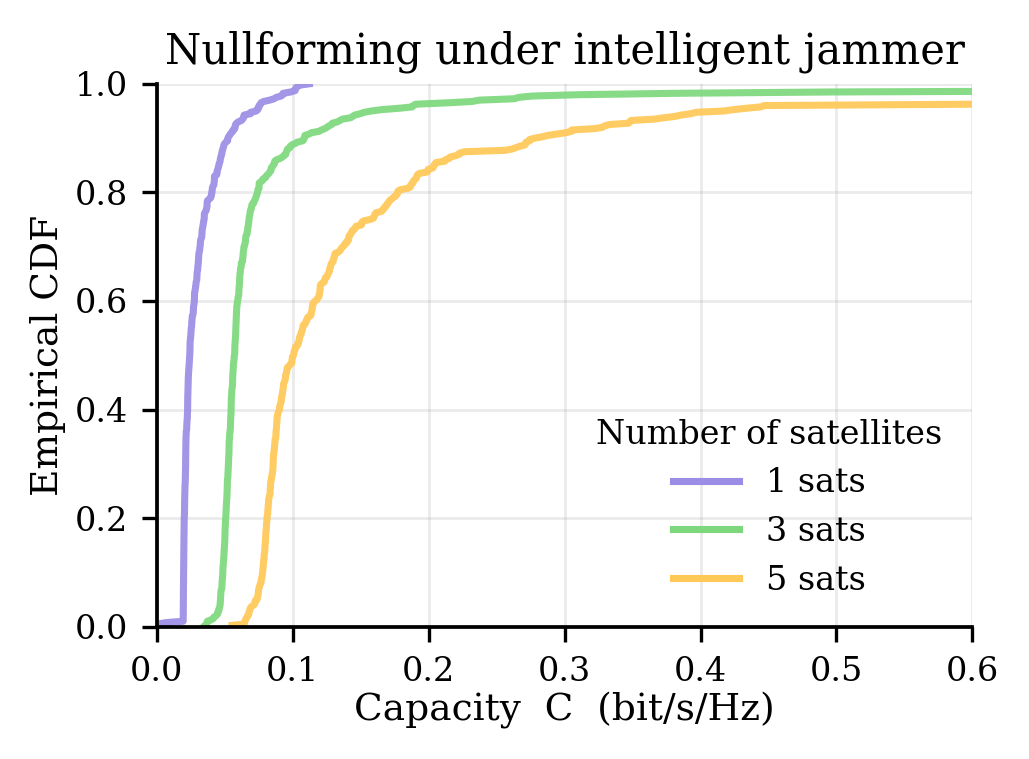

In [3]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from matplotlib.lines import Line2D

# ====== Load JSONL ======
jsonl_path = Path("allarray1km.jsonl")
data = []
with jsonl_path.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        data.append(json.loads(line))

# ====== Aggregate last J by k ======
J_last_by_k = defaultdict(list)
for entry in data:
    hist = entry.get("hist", {})
    J_series = hist.get("J", [])
    if not J_series:
        continue
    k = entry.get("k")
    if k is None:
        continue
    J_last = np.real(J_series[-1])
    J_last_by_k[int(k)].append(J_last)

# ====== Prepare ECDF ======
def ecdf(vals):
    x = np.sort(np.asarray(vals, dtype=float))
    if x.size == 0:
        return np.array([]), np.array([])
    y = np.arange(1, x.size + 1) / x.size
    return x, y

ks_sorted = sorted(J_last_by_k.keys())

# ====== IEEE single-column styling ======
fig_size = (3.5, 2.6)   # inches (IEEE single column)
dpi      = 300
base_font = 9

plt.rcParams.update({
    "figure.dpi": dpi,
    "font.size": base_font,
    "axes.titlesize": base_font + 1,
    "axes.labelsize": base_font,
    "xtick.labelsize": base_font - 1,
    "ytick.labelsize": base_font - 1,
    "legend.fontsize": base_font - 1,
    "axes.linewidth": 0.9,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
})

fig, ax = plt.subplots(figsize=fig_size)

# ====== New palette: brighter & lighter (different from previous) ======
# 天蓝 / 玫红 / 柔金 / 薄荷绿 / 薰衣草（会按需要循环）
soft_bright_colors = ["#9B8DE5", "#7DD87D", "#FFC857", "#55C1FF", "#FF7AA2"]
colors = [soft_bright_colors[i % len(soft_bright_colors)] for i in range(max(1, len(ks_sorted)))]

# ====== Axes polish ======
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.25, linewidth=0.7)

# ====== Plot ECDF curves ======
lw = 1.7  # line width for paper
for i, k_sel in enumerate(ks_sorted):
    x, y = ecdf(J_last_by_k[k_sel])
    if x.size == 0:
        continue
    ax.plot(
        x, y,
        color=colors[i],
        linewidth=lw,
        label=f"{k_sel} sats",
        alpha=0.92  # 轻微透明，显得更柔和
    )

# ====== Labels / limits / title ======
ax.set_xlabel("Capacity  C  (bit/s/Hz)", labelpad=1)
ax.set_ylabel("Empirical CDF", labelpad=2)
ax.set_title("Nullforming under intelligent jammer", pad=5)
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 1.0)

# ====== Legend (k only) ======
handles = [
    Line2D([0], [0], color=colors[i], lw=lw, label=f"{k_sel} sats")
    for i, k_sel in enumerate(ks_sorted)
]
ax.legend(
    handles=handles,
    title="Number of satellites",
    frameon=False,
    title_fontsize=base_font - 1,
    loc="lower right"
)

plt.tight_layout()

# ====== Save (paper-ready) ======
out_dir = Path("result_plot")
out_dir.mkdir(parents=True, exist_ok=True)
out_png = out_dir / "cdf_intelligent_jammer.png"
out_pdf = out_dir / "cdf_intelligent_jammer.pdf"
fig.savefig(out_png, dpi=dpi, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")  # vector for LaTeX
plt.show()


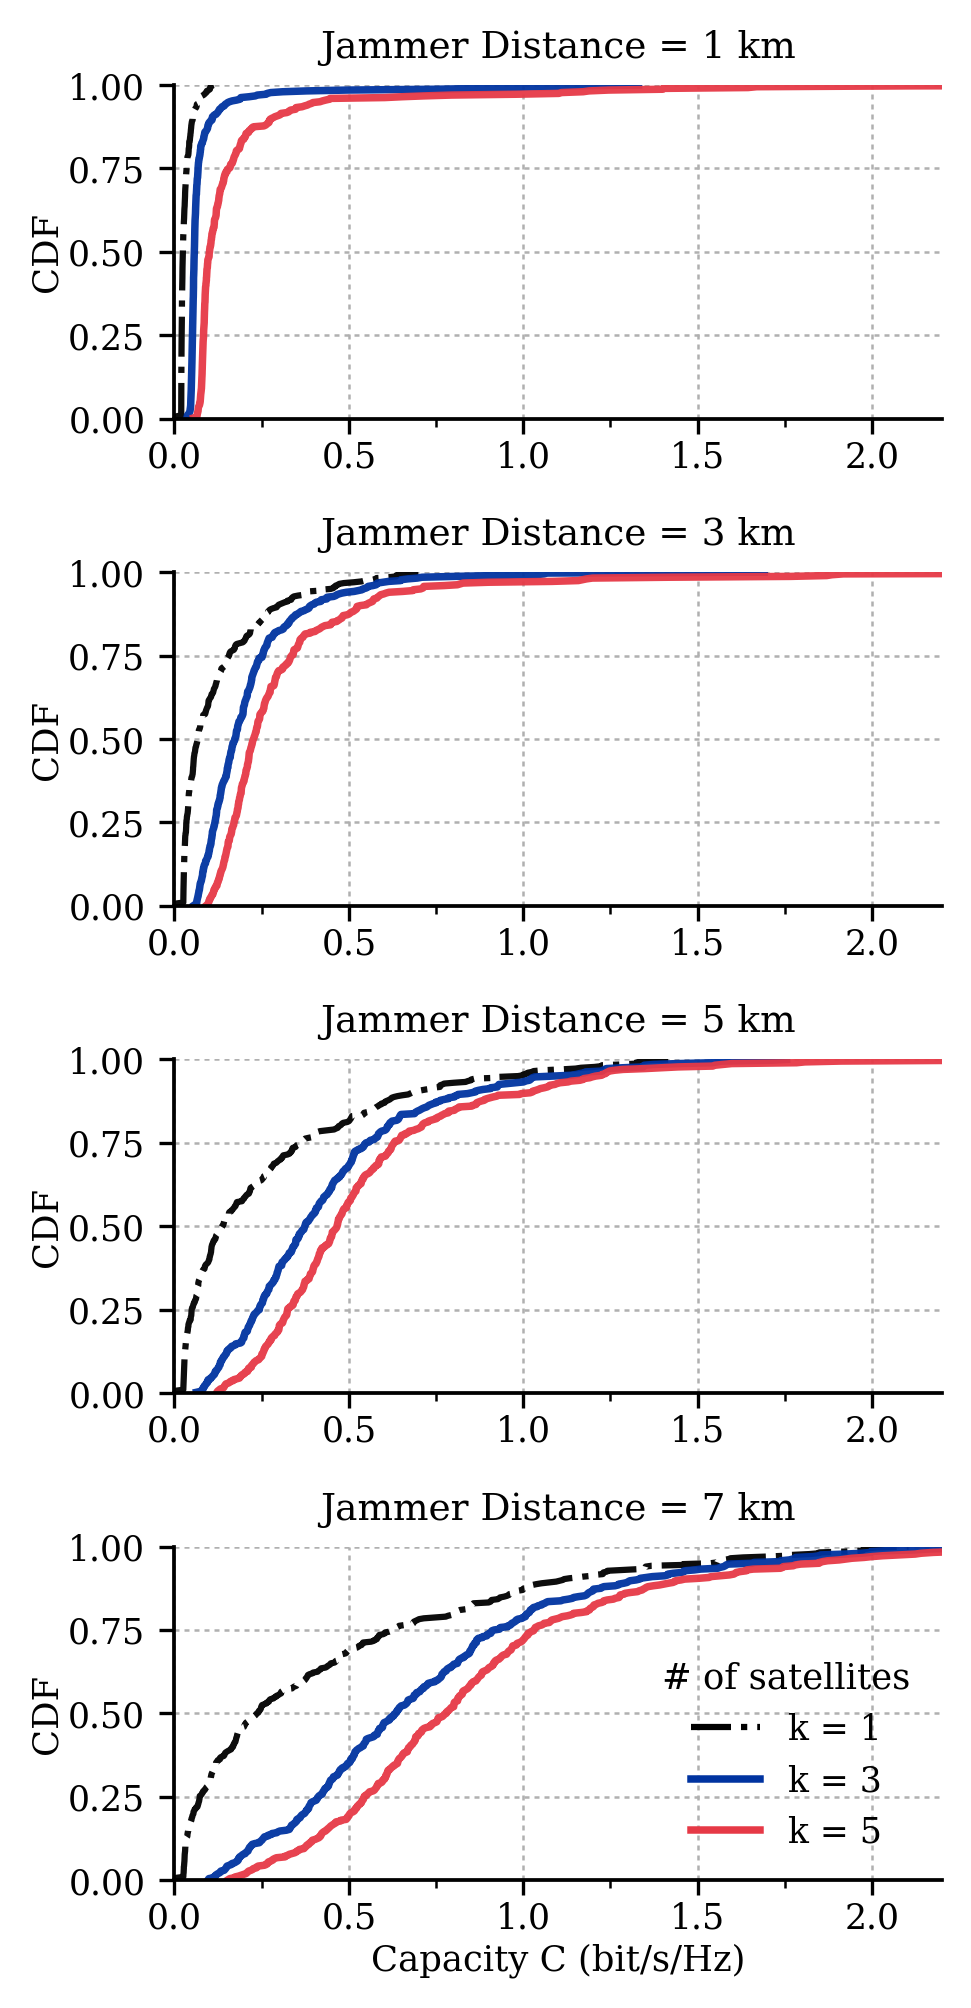

In [65]:
# %%
# -*- coding: utf-8 -*-
import json, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

# ============ 工具函数 ============
def load_J_last_by_k(jsonl_path: Path):
    J_last_by_k = defaultdict(list)
    if not jsonl_path.exists():
        return {}
    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                hist = entry.get("hist", {})
                J_series = hist.get("J", [])
                if not J_series:
                    continue
                k = entry.get("k"); 
                if k is None:
                    continue
                J_last = float(np.real(J_series[-1]))
                J_last_by_k[int(k)].append(J_last)
            except Exception:
                continue
    return J_last_by_k

def ecdf(vals):
    x = np.sort(np.asarray(vals, dtype=float))
    if x.size == 0: return np.array([]), np.array([])
    y = np.arange(1, x.size + 1) / x.size
    return x, y

def ensure_demo_if_empty(data_by_dist, k_list, seed=42):
    rng = np.random.default_rng(seed)
    for dist in data_by_dist:
        if len(data_by_dist[dist]) == 0:
            shift = {"1 km": 0.2, "3 km": 0.6, "5 km": 1.0, "7 km": 1.3}.get(dist, 0.5)
            data_by_dist[dist] = {}
            for k in k_list:
                mu = shift + 0.15 * (k - min(k_list))
                vals = rng.lognormal(mean=mu, sigma=0.25, size=200)
                data_by_dist[dist][k] = vals.tolist()
    return data_by_dist

# ============ 数据读取 ============
paths = {
    "1 km": Path("allarray1km.jsonl"),
    "3 km": Path("allarray3km.jsonl"),
    "5 km": Path("allarray5km.jsonl"),
    "7 km": Path("allarray7km.jsonl"),
}
data_by_dist = {d: load_J_last_by_k(p) for d,p in paths.items()}
all_k_sets = [set(d.keys()) for d in data_by_dist.values() if d]
common_ks = sorted(set.intersection(*all_k_sets)) if all_k_sets else []
k_list = common_ks if common_ks else [1,3,5]
data_by_dist = ensure_demo_if_empty(data_by_dist, k_list)

# ============ 样式 ============
fig_size = (3.3, 6.8)   # 略加高，为四图保留足够间距
dpi = 300
base_font = 8.5
plt.rcParams.update({
    "figure.dpi": dpi,
    "font.size": base_font,
    "axes.titlesize": base_font + 0.5,
    "axes.labelsize": base_font,
    "xtick.labelsize": base_font - 0.2,
    "ytick.labelsize": base_font - 0.2,
    "legend.fontsize": base_font - 0.2,
    "axes.linewidth": 0.9,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
})

# 每幅图单独 xlim
xlim_map = {
    "1 km": (0.0,2.2),
    "3 km": (0.0, 2.2),
    "5 km": (0.0, 2.2),
    "7 km": (0.0, 2.2),
}
dist_order = ["1 km","3 km","5 km","7 km"]

# 关闭 constrained_layout，用 hspace 控制垂直间距（避免重叠的关键）
fig, axes = plt.subplots(4, 1, figsize=fig_size, constrained_layout=False)
# —— 关键：增加子图间距，并给刻度与标题留出空间
plt.subplots_adjust(hspace=0.46, top=0.98, bottom=0.10)

palette = ['black', '#0033A0', '#E63946', '#6C757D', '#2CA02C']
colors_by_k = {k: palette[i % len(palette)] for i,k in enumerate(k_list)}
min_k = min(k_list)
linestyle_by_k = {k: ('-.' if k == min_k else '-') for k in k_list}
linewidth_by_k = {k: (1.5 if k == min_k else 1.8) for k in k_list}

for idx, (ax, dist) in enumerate(zip(axes, dist_order)):
    # 边框与网格
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=1, linewidth=0.6, linestyle=(0,(2,2)))

    # 每轴独立刻度器
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    # 曲线
    for k in k_list:
        x, y = ecdf(data_by_dist[dist].get(k, []))
        if x.size == 0: continue
        ax.plot(x, y, color=colors_by_k[k], linestyle=linestyle_by_k[k],
                linewidth=linewidth_by_k[k], alpha=0.95, antialiased=True)

    ax.set_xlim(*xlim_map[dist])
    ax.set_ylim(0, 1.0)
    # —— 关键：给标题更大的 pad，并稍微上移
    ax.set_title(f"Jammer Distance = {dist}", pad=5, y=1.02)
    ax.set_ylabel("CDF", labelpad=1)
    ax.margins(x=0.02)

    # —— 关键：控制刻度文字距离轴线的像素距离（pad 小一些）
    ax.tick_params(axis='x', which='major', pad=1.5)
    ax.tick_params(axis='x', which='minor', pad=1.0)

    # 若不想所有子图都有底部刻度文字，可改为仅最后一张有：
    # if idx < len(axes)-1:
    #     ax.tick_params(labelbottom=False)

# 底部统一 xlabel
axes[-1].set_xlabel("Capacity C (bit/s/Hz)", labelpad=2)

# ===== 方案B（可选）：把上三张的 x 刻度文字移到顶部，根治重叠 =====
# for ax in axes[:-1]:
#     ax.tick_params(axis='x', labelbottom=False, bottom=False, top=True, labeltop=True, pad=1.5)

# 图例
legend_handles = [Line2D([0],[0], color=colors_by_k[k], linestyle=linestyle_by_k[k],
                         lw=linewidth_by_k[k], label=f"k = {k}") for k in k_list]
axes[-1].legend(handles=legend_handles, frameon=False, loc="lower right", title="# of satellites")

plt.show()
out_dir = Path("result_plot")
out_dir.mkdir(exist_ok=True)

fig.savefig(out_dir / "ecdf_4x1.png",
            dpi=600, bbox_inches="tight", transparent=False)

fig.savefig(out_dir / "ecdf_4x1.pdf",
            bbox_inches="tight", transparent=False)

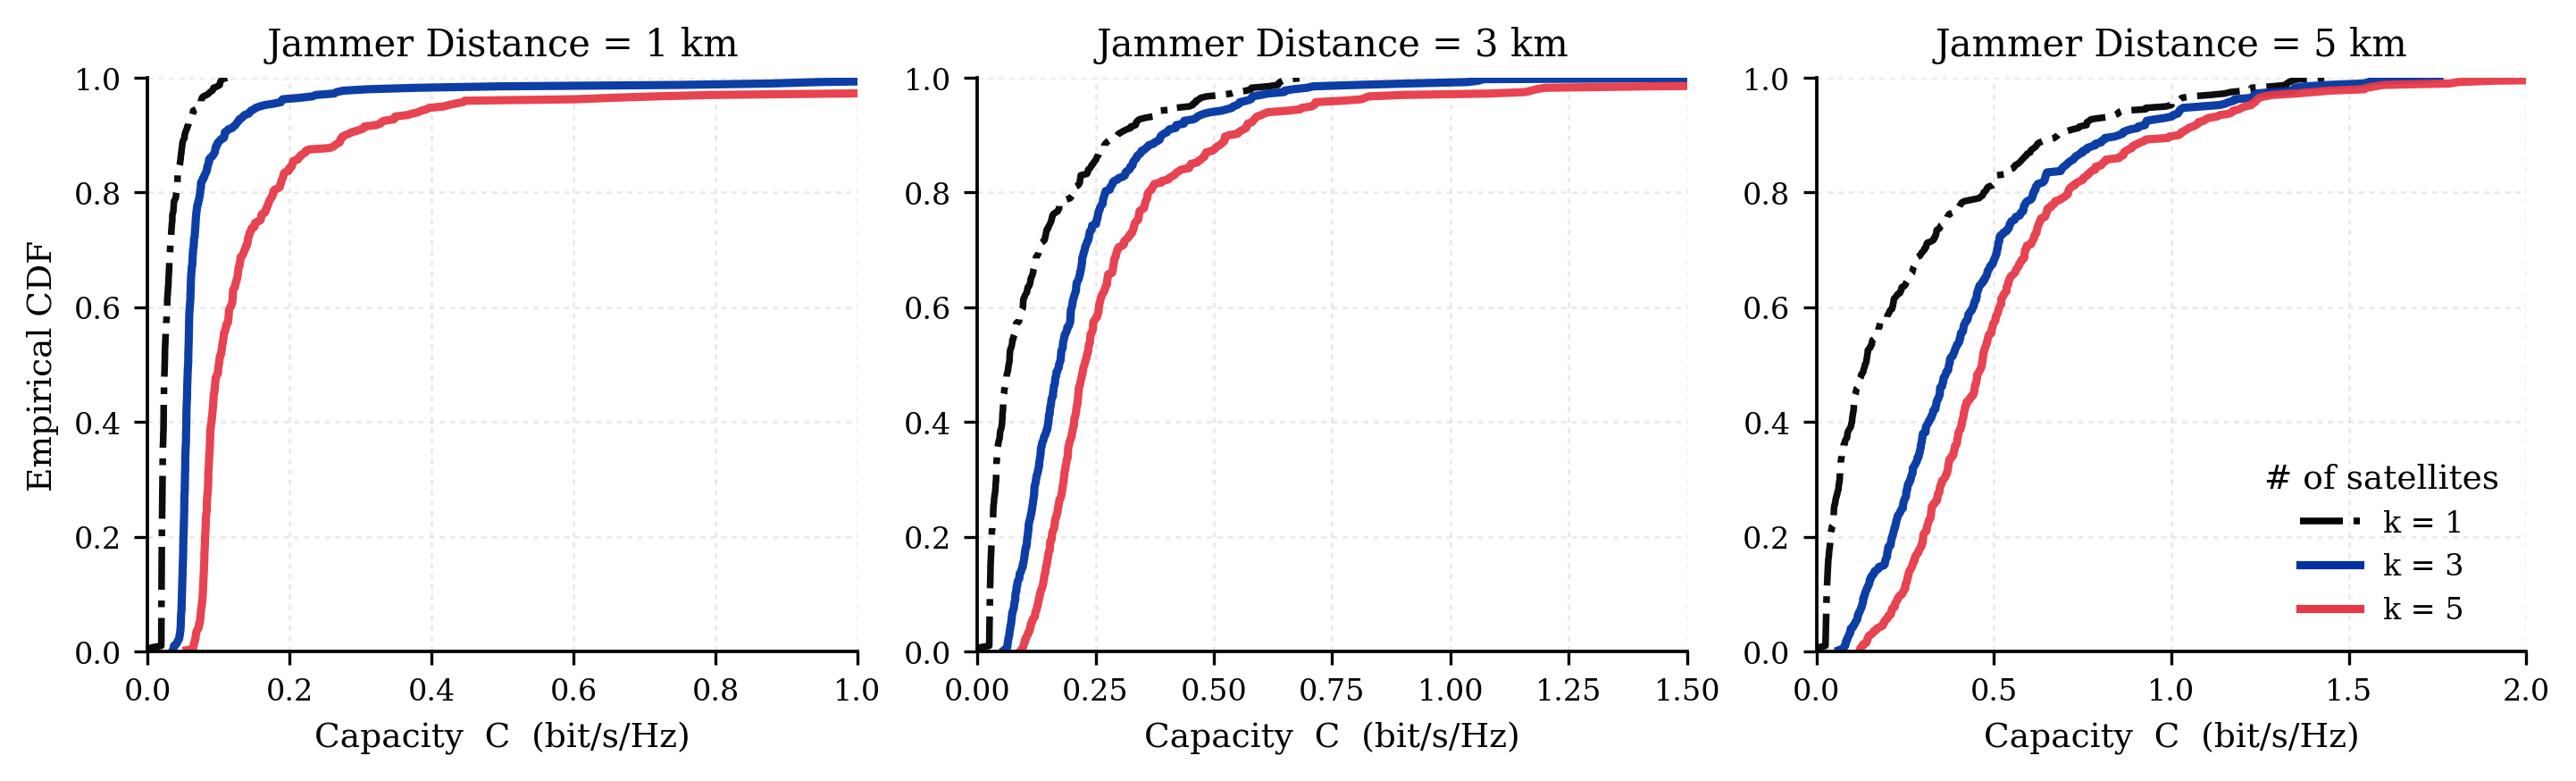

In [36]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from matplotlib.lines import Line2D

# ---------- 工具函数 ----------
def load_J_last_by_k(jsonl_path: Path):
    J_last_by_k = defaultdict(list)
    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            entry = json.loads(line)
            hist = entry.get("hist", {})
            J_series = hist.get("J", [])
            if not J_series:
                continue
            k = entry.get("k")
            if k is None:
                continue
            J_last = float(np.real(J_series[-1]))
            J_last_by_k[int(k)].append(J_last)
    return J_last_by_k

def ecdf(vals):
    x = np.sort(np.asarray(vals, dtype=float))
    if x.size == 0:
        return np.array([]), np.array([])
    y = np.arange(1, x.size + 1) / x.size
    return x, y

# ---------- 读取三个距离 ----------
paths = {
    "1 km": Path("allarray1km.jsonl"),
    "3 km": Path("allarray3km.jsonl"),
    "5 km": Path("allarray5km.jsonl"),
}
data_by_dist = {dist: load_J_last_by_k(p) for dist, p in paths.items()}

# 共同的 k（可手动指定）
common_ks = sorted(set.intersection(*[set(d.keys()) for d in data_by_dist.values()]))
k_list = common_ks if common_ks else [1, 3, 5]

# ---------- 手动指定各距离的横轴范围 ----------
xlim_map = {
    "1 km": (0.0, 1.0),
    "3 km": (0.0, 1.5),
    "5 km": (0.0, 2.0),
}

# ---------- 绘图 ----------
fig_size = (9.5, 2.8)   # 横向布局
dpi = 300
base_font = 9
plt.rcParams.update({
    "figure.dpi": dpi,
    "font.size": base_font,
    "axes.titlesize": base_font + 1,
    "axes.labelsize": base_font,
    "xtick.labelsize": base_font - 1,
    "ytick.labelsize": base_font - 1,
    "legend.fontsize": base_font - 1,
    "axes.linewidth": 0.9,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
})

dist_order = ["1 km", "3 km", "5 km"]
fig, axes = plt.subplots(1, 3, figsize=fig_size, constrained_layout=True)

# 颜色：确保最小的 k 用黑色
palette = ['black', '#0033A0', '#E63946', '#6C757D', '#2CA02C']
colors_by_k = {k: palette[i % len(palette)] for i, k in enumerate(k_list)}

# 线型/线宽：最小 k → 点线+更细；其余 k → 实线
min_k = min(k_list)
linestyle_by_k = {k: ('-.' if k == min_k else '-') for k in k_list}
linewidth_by_k = {k: (1.8 if k == min_k else 2.2) for k in k_list}

for idx, (ax, dist) in enumerate(zip(axes, dist_order)):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.25, linewidth=0.7, linestyle=(0, (2, 2)))

    for k in k_list:
        vals = data_by_dist[dist].get(k, [])
        x, y = ecdf(vals)
        if x.size == 0:
            continue

        ax.plot(
            x, y,
            color=colors_by_k[k],
            linestyle=linestyle_by_k[k],   # ★ 按 k 指定线型
            linewidth=linewidth_by_k[k],   # ★ 按 k 指定线宽
            alpha=0.95,
            label=f"k = {k}",
            antialiased=True
        )

    # 坐标范围
    if dist in xlim_map:
        ax.set_xlim(*xlim_map[dist])
    else:
        all_vals = np.concatenate(
            [data_by_dist[dist].get(k, []) for k in k_list if len(data_by_dist[dist].get(k, [])) > 0]
        )
        if all_vals.size:
            ax.set_xlim(np.min(all_vals) * 0.95, np.max(all_vals) * 1.05)

    ax.set_ylim(0, 1.0)
    ax.set_title(f"Jammer Distance = {dist}")
    ax.set_xlabel("Capacity  C  (bit/s/Hz)")
    ax.set_ylabel("Empirical CDF" if idx == 0 else "")

# 图例（与曲线样式保持一致）
legend_handles = [
    Line2D([0], [0],
           color=colors_by_k[k],
           linestyle=linestyle_by_k[k],
           lw=linewidth_by_k[k],
           label=f"k = {k}")
    for k in k_list
]
axes[-1].legend(handles=legend_handles, frameon=False, loc="lower right", title="# of satellites")

# 保存
out_dir = Path("result_plot")
out_dir.mkdir(parents=True, exist_ok=True)
# fig.savefig(out_dir / "cdf_1x3_by_distance_manual_xlim.png", dpi=dpi, bbox_inches="tight")
# fig.savefig(out_dir / "cdf_1x3_by_distance_manual_xlim.pdf", bbox_inches="tight")
plt.show()


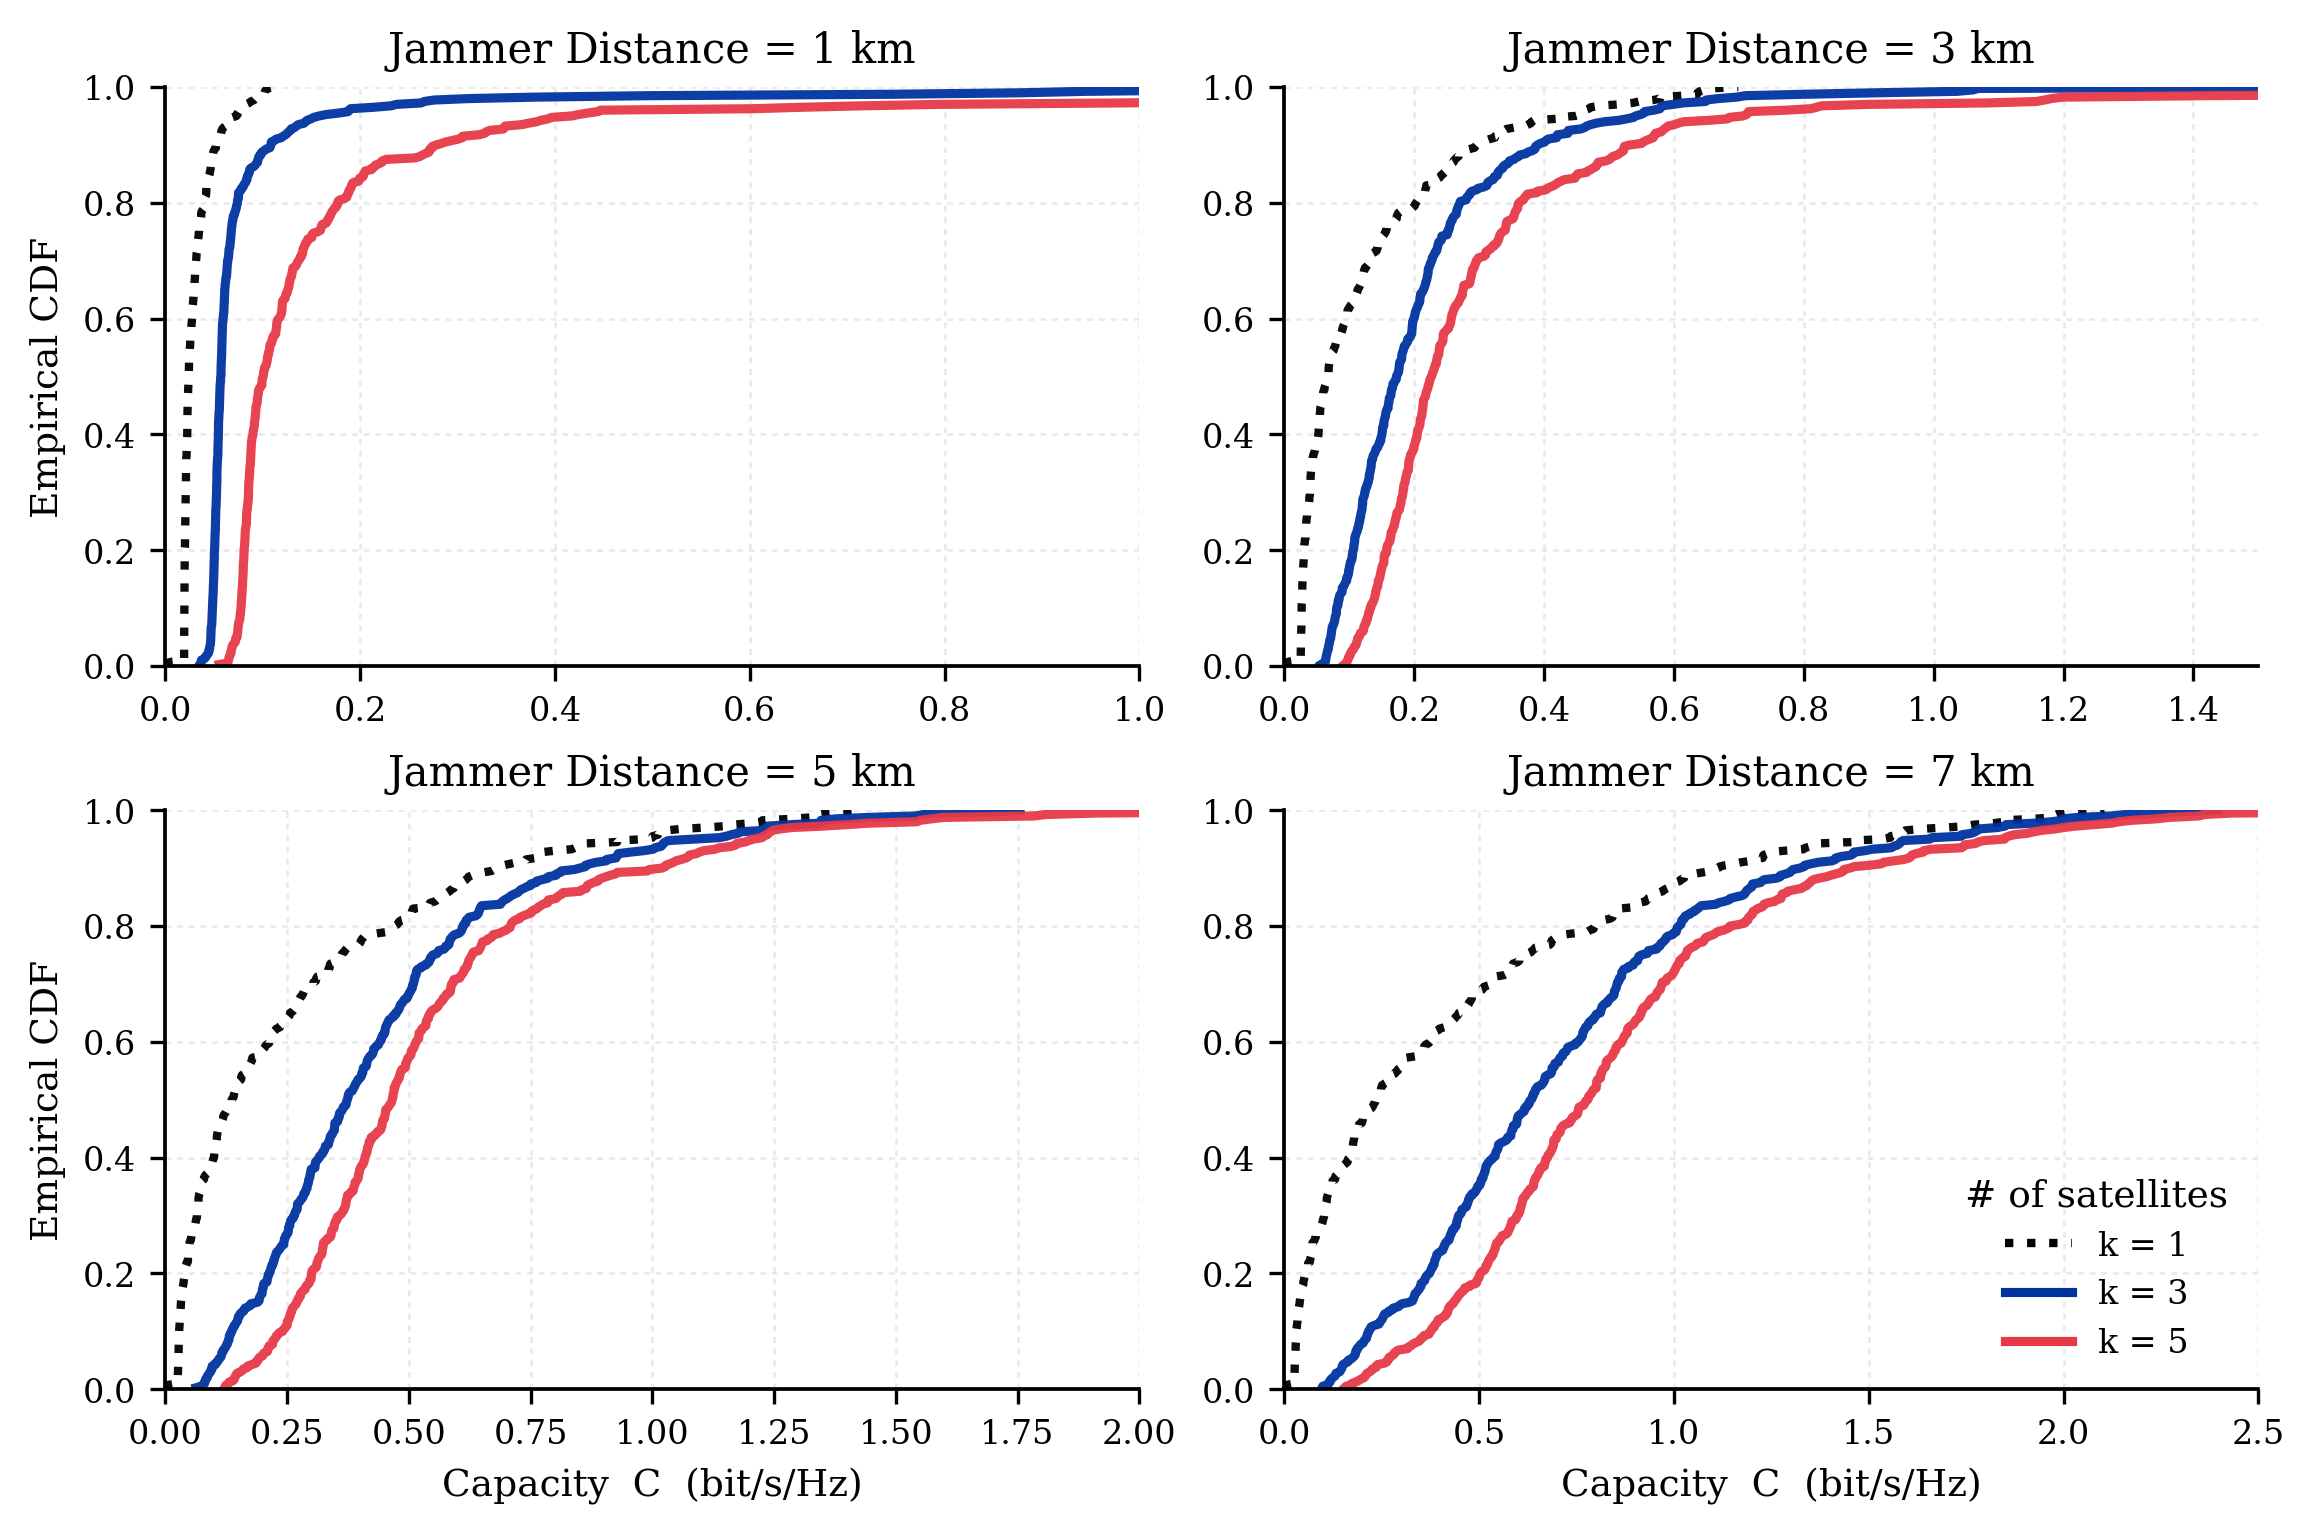

In [40]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from matplotlib.lines import Line2D

# ---------- 工具函数 ----------
def load_J_last_by_k(jsonl_path: Path):
    J_last_by_k = defaultdict(list)
    if not jsonl_path.exists():
        print(f"[warn] file not found: {jsonl_path}")
        return J_last_by_k
    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            entry = json.loads(line)
            hist = entry.get("hist", {})
            J_series = hist.get("J", [])
            if not J_series:
                continue
            k = entry.get("k")
            if k is None:
                continue
            J_last = float(np.real(J_series[-1]))
            J_last_by_k[int(k)].append(J_last)
    return J_last_by_k

def ecdf(vals):
    x = np.sort(np.asarray(vals, dtype=float))
    if x.size == 0:
        return np.array([]), np.array([])
    y = np.arange(1, x.size + 1) / x.size
    return x, y

# ---------- 读取四个距离 ----------
paths = {
    "1 km": Path("allarray1km.jsonl"),
    "3 km": Path("allarray3km.jsonl"),
    "5 km": Path("allarray5km.jsonl"),
    "7 km": Path("allarray7km.jsonl"),
}
data_by_dist = {dist: load_J_last_by_k(p) for dist, p in paths.items()}

# 共同的 k（可手动指定）
common_ks = sorted(set.intersection(*[set(d.keys()) for d in data_by_dist.values()])) if all(data_by_dist.values()) else []
k_list = common_ks if common_ks else [1, 3, 5]

# ---------- 手动指定各距离的横轴范围 ----------
xlim_map = {
    "1 km": (0.0, 1.0),
    "3 km": (0.0, 1.5),
    "5 km": (0.0, 2.0),
    "7 km": (0.0, 2.5),
}

# ---------- 绘图 ----------
fig_size = (7.6, 5.0)  # 2×2 单页布局
dpi = 300
base_font = 9
plt.rcParams.update({
    "figure.dpi": dpi,
    "font.size": base_font,
    "axes.titlesize": base_font + 1,
    "axes.labelsize": base_font,
    "xtick.labelsize": base_font - 1,
    "ytick.labelsize": base_font - 1,
    "legend.fontsize": base_font - 1,
    "axes.linewidth": 0.9,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
})

dist_order = ["1 km", "3 km", "5 km", "7 km"]
fig, axes = plt.subplots(2, 2, figsize=fig_size, constrained_layout=True)
axes = axes.ravel()

# 颜色：确保最小的 k 用黑色
palette = ['black', '#0033A0', '#E63946', '#6C757D', '#2CA02C']
colors_by_k = {k: palette[i % len(palette)] for i, k in enumerate(k_list)}

# 线型/线宽：最小 k → 点线+更细；其余 k → 实线
min_k = min(k_list)
linestyle_by_k = {k: (':' if k == min_k else '-') for k in k_list}
linewidth_by_k = {k: (2.0 if k == min_k else 2.2) for k in k_list}

for idx, (ax, dist) in enumerate(zip(axes, dist_order)):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.25, linewidth=0.7, linestyle=(0, (2, 2)))

    for k in k_list:
        vals = data_by_dist.get(dist, {}).get(k, [])
        x, y = ecdf(vals)
        if x.size == 0:
            continue

        ax.plot(
            x, y,
            color=colors_by_k[k],
            linestyle=linestyle_by_k[k],
            linewidth=linewidth_by_k[k],
            alpha=0.95,
            label=f"k = {k}",
            antialiased=True
        )

    # 坐标范围
    if dist in xlim_map:
        ax.set_xlim(*xlim_map[dist])
    else:
        all_vals = np.concatenate(
            [data_by_dist.get(dist, {}).get(k, []) for k in k_list if len(data_by_dist.get(dist, {}).get(k, [])) > 0]
        ) if any(len(data_by_dist.get(dist, {}).get(k, [])) > 0 for k in k_list) else np.array([])
        if all_vals.size:
            ax.set_xlim(np.min(all_vals) * 0.95, np.max(all_vals) * 1.05)

    ax.set_ylim(0, 1.0)
    ax.set_title(f"Jammer Distance = {dist}")
    # 左列显示 y 轴标签，下列显示 x 轴标签
    if idx in (0, 2):
        ax.set_ylabel("Empirical CDF")
    else:
        ax.set_ylabel("")
    if idx in (2, 3):
        ax.set_xlabel("Capacity  C  (bit/s/Hz)")
    else:
        ax.set_xlabel("")

# 图例（与曲线样式保持一致）放在右下角子图
legend_handles = [
    Line2D([0], [0],
           color=colors_by_k[k],
           linestyle=linestyle_by_k[k],
           lw=linewidth_by_k[k],
           label=f"k = {k}")
    for k in k_list
]
axes[-1].legend(handles=legend_handles, frameon=False, loc="lower right", title="# of satellites")

# 保存
out_dir = Path("result_plot")
out_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "cdf_2x2_by_distance.png", dpi=dpi, bbox_inches="tight")
fig.savefig(out_dir / "cdf_2x2_by_distance.pdf", bbox_inches="tight")
plt.show()


In [27]:
import json
import matplotlib.pyplot as plt

def inspect_J_curve(filepath, method, step_idx):
    """
    检查结果文件中某个方法(method)和时间步(step_idx)对应的 J 曲线。
    
    Args:
        filepath : str, JSONL 文件路径 (如 "results_hist.jsonl")
        method   : str, 方法名 (例如 "MirrorProx" 或 "BestResp")
        step_idx : int, 要查看的 step 索引 (即你的 for 循环中的 step_idx)
    Returns:
        int : J 的长度
    """
    # 逐行读取文件
    with open(filepath, "r", encoding="utf-8") as f:
        entries = [json.loads(line) for line in f if line.strip()]
    
    # 过滤出对应的方法和step
    matches = [e for e in entries if e.get("method") == method and e.get("step_idx") == step_idx]
    
    if len(matches) == 0:
        print(f"⚠️ 没找到 method='{method}', step={step_idx} 的数据")
        return None
    
    # 通常每个 step 可能有多个 k（1,3,5）
    for e in matches:
        k = e.get("k")
        hist = e.get("hist", {})
        J = hist.get("J", [])
        if not J:
            print(f"⚠️ k={k} 没有 J 数据")
            continue
        
        print(f"✅ method={method}, step={step_idx}, k={k}, len(J)={len(J)}")
        plt.plot(J, label=f"{method} k={k} (len={len(J)})")

    plt.xlabel("Iteration")
    plt.ylabel("J value")
    plt.title(f"J evolution: method={method}, step={step_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return


✅ method=BestResp, step=17, k=1, len(J)=200
✅ method=BestResp, step=17, k=3, len(J)=200
✅ method=BestResp, step=17, k=5, len(J)=200


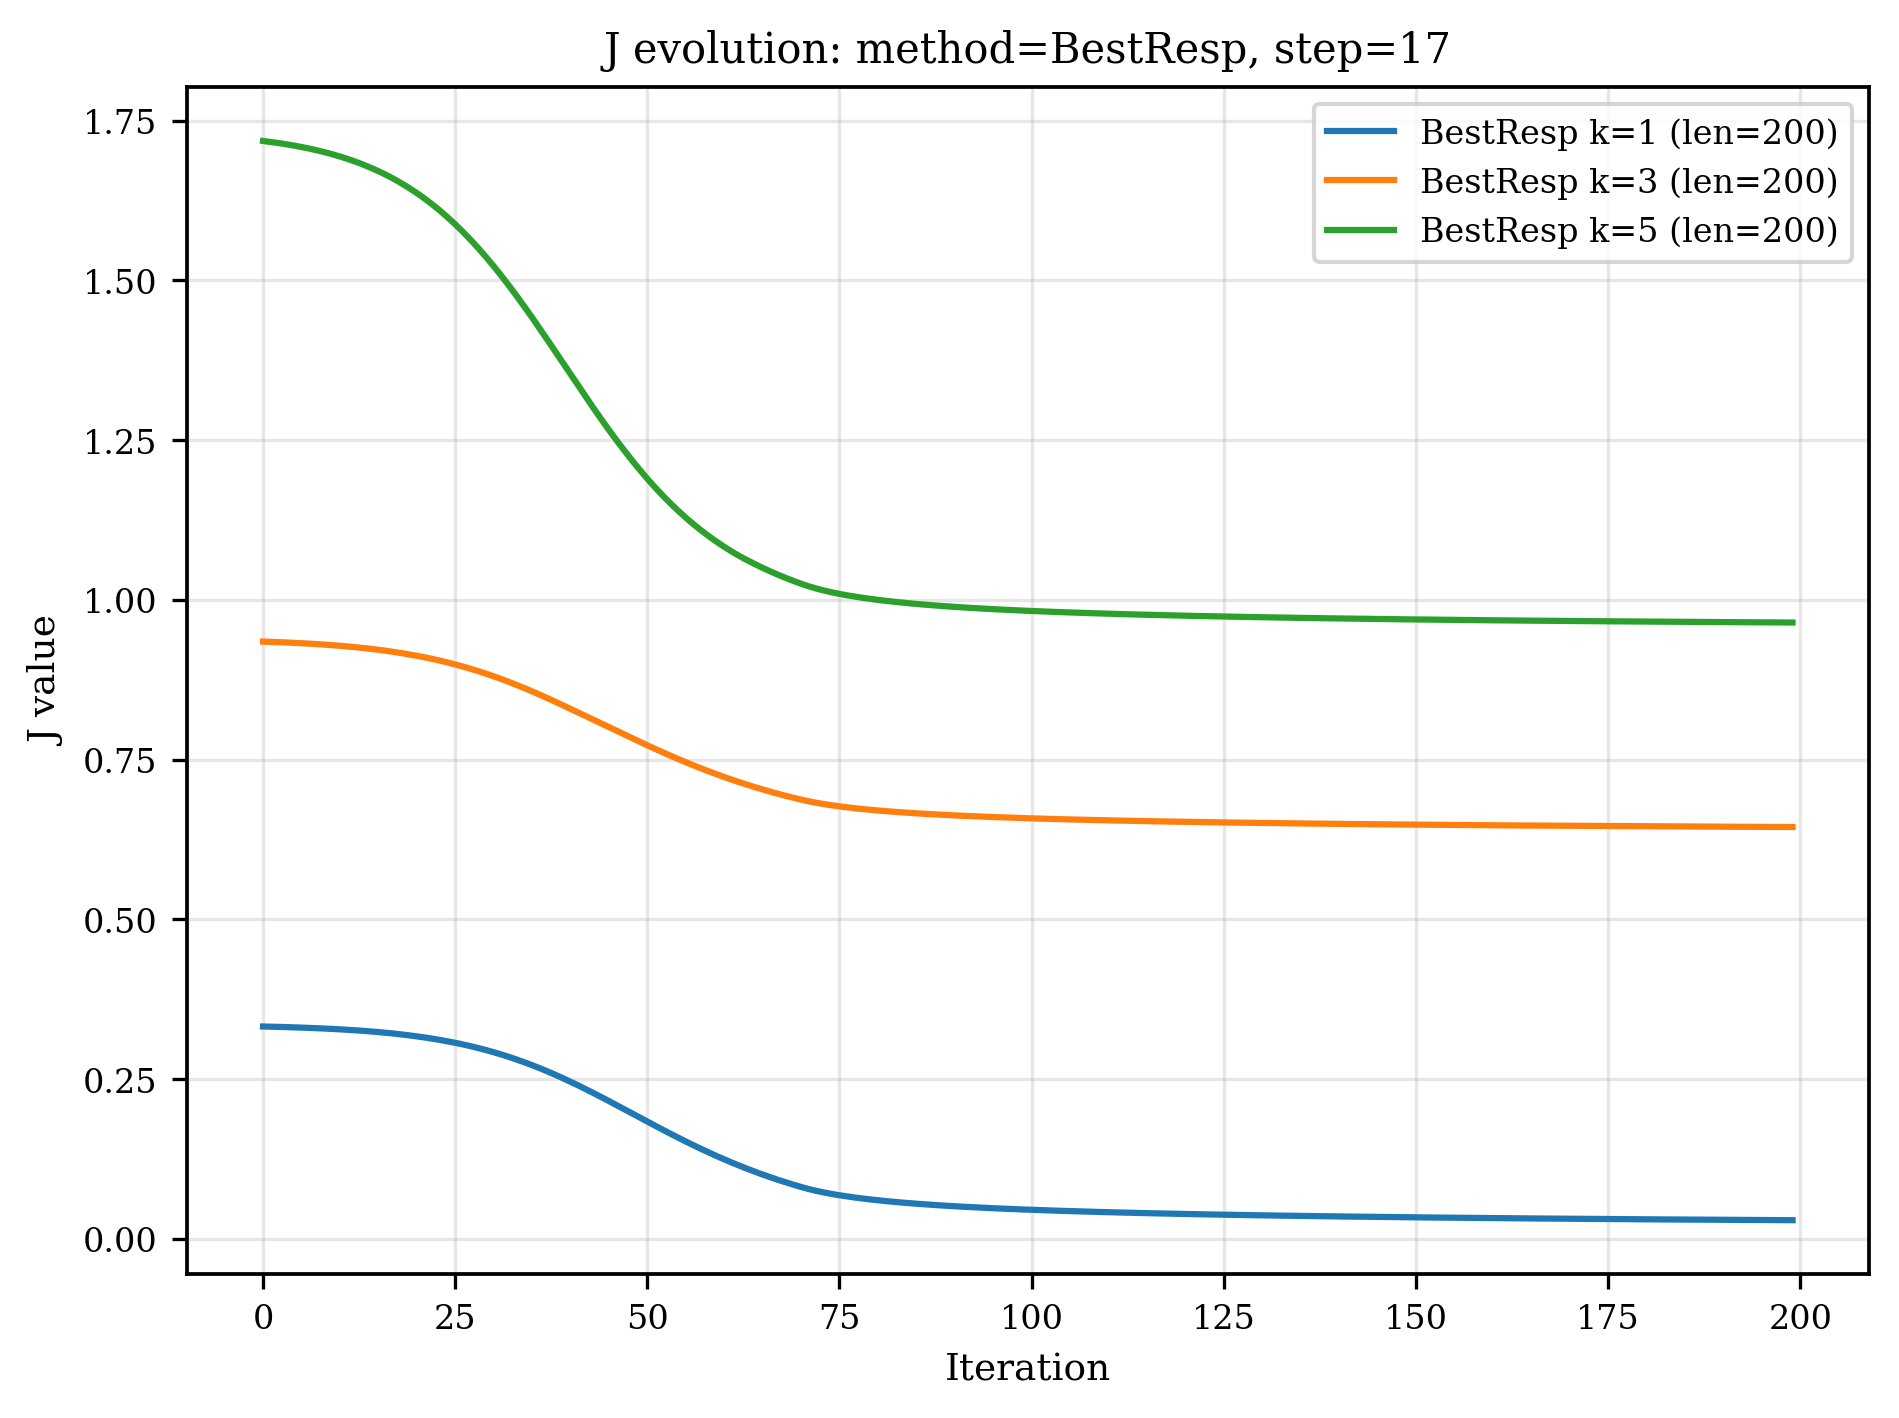

In [31]:
inspect_J_curve("allarray7km.jsonl", method="BestResp", step_idx=17)